<a href="https://colab.research.google.com/github/jvera672/cd_202202_juan_vera/blob/main/Copia_de_Funci%C3%B3n_K_de_Ripley.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **La Función K de Ripley**
La función K, propuesta por Brian D. Ripley en 1976, representa la media observada del número de puntos dentro de una distancia definida dividida por la densidad de puntos en el área de estudio.

La forma general de la función K está dada por la ecuación:

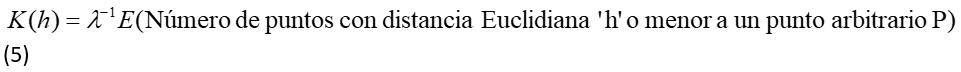

Donde λ es la densidad de puntos en el área. El valor de la función K para un fenómeno aleatoriamente distribuido es igual a πh^2.

Para estimar el valor de la función K se parte del valor estimado de E, denominado operador de expectación, que para espacios planos se estima mediante la ecuación:

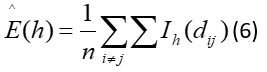

Donde h es la distancia máxima entre los puntos a ser tomada en consideración, n es el número total de puntos, dij es la distancia euclidiana entre dos puntos i y j, Ih() es una función de peso con valor uno (1) cuando la distancia entre los puntos es menor o igual a h y valor cero (0) cuando esta distancia es superior a h y R es el área del espacio estudiado. La densidad de puntos λ se puede estimar como:

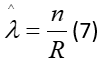

Al remplazar las funciones (6) y (7) sobre la función (5) se obtiene el estimador de la función K para espacios planos dado por la ecuación:

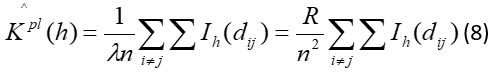

La siguiente figura muestra las distancias dij menores o iguales a h para dos puntos arbitrarios dentro del área de estudio.

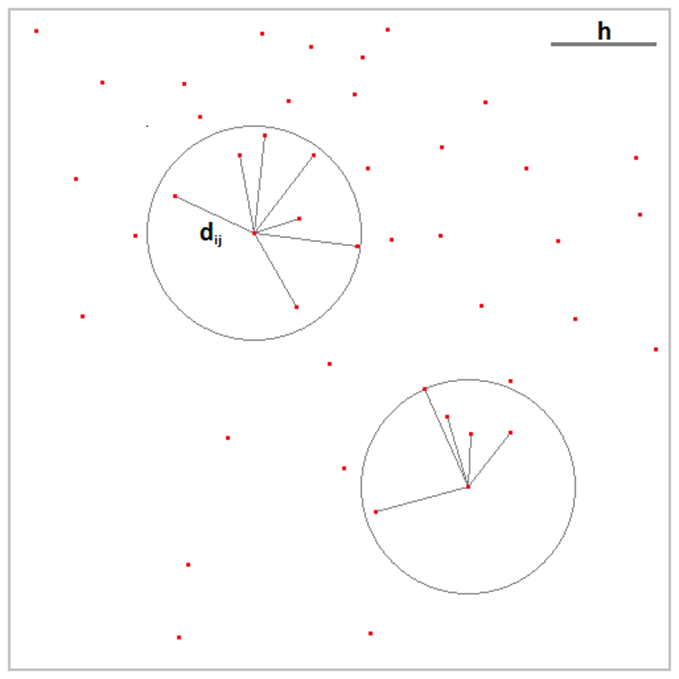

La función K puede ser utilizada para determinar si una serie de puntos ubicados sobre un espacio tienden a formar grupos o por el contrario se distribuye de forma aleatoria; una forma de poner a prueba estas afirmaciones es por medio de simulaciones de Monte Carlo. Para esto se genera una gran cantidad de conjuntos aleatorios de puntos sobre el mismo espacio (por ejemplo 1.000 conjuntos), la función K se aplica con diferentes valores de h (distancia máxima entre puntos a tenerse en cuenta) sobre cada uno de los conjuntos de datos aleatorios generados y sobre el conjunto original de puntos. Con los resultados de la función K sobre los conjuntos aleatorios para cada valor de h se definen intervalos de confianza, por ejemplo del 95% (entre el valor que ocupa el percentil 2,5 y el valor que ocupa el percentil 97,5), si el valor de la función K para el conjunto de datos original es superior al intervalo de confianza definido se puede concluir que existe tendencia estadísticamente significativa a formar agrupaciones y por lo tanto la distribución de los datos sobre el espacio no es aleatoria.

In [1]:
!pip install pyproj
!pip install cython
!pip install cartopy
!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    
!pip install shapely --no-binary shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.1 MB/s 
Found existing installation: Shapely 1.8.5.post1
Uninstalling Shapely-1.8.5.post1:
  Successfully uninstalled Shapely-1.8.5.post1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Shapely-1.8.5.post1.tar.gz (200 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for shapely: filename=Shapely-1.8.5.post1-cp37-cp37m-linux_x86_64.whl size=669749 sha256=29cfb1237981053fe23a14a6094fb1f891e2e197994348d4bd652fef22a76161
  Stored in directory: /roo

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np

import cartopy
import cartopy.crs as ccrs                   # for projections
import cartopy.feature as cfeature           # for features
import cartopy.io.shapereader as shapereader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.feature.nightshade import Nightshade

In [3]:
import pandas as pd
import pyproj

In [4]:
!apt-get install nvidia-cuda-toolkit
!pip3 install numba

import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/lib/nvidia-cuda-toolkit/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/lib/x86_64-linux-gnu/libnvvm.so"

from numba import cuda
import numpy as np
import time

Reading package lists... Done
Building dependency tree       
Reading state information... Done
nvidia-cuda-toolkit is already the newest version (9.1.85-3ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
ruta = 'https://foscalinternacional.com/datasets/eventos_dengue_2020.csv'
df = pd.read_csv(ruta)
df

,ID,fec_not,semana,año,edad_,uni_med_,sexo_,cod_pais_o,cod_dpto_o,cod_mun_o,...,hipotension,hepatomegalia,hemorragia_mucosa,hipotermia,caida_plaquetas,acum_liquido,aum_hematocrito,conducta,latitud,longitud
0,1,17/01/2020,1,2020,25,1,F,170,68,276,...,2,2,2,2,2,2,2,1. Ambulatorio,7.076011,-73.102501
1,2,10/01/2020,1,2020,24,1,M,170,68,276,...,2,2,2,2,2,2,2,1. Ambulatorio,7.079495,-73.105400
2,3,12/01/2020,1,2020,58,1,M,170,68,276,...,2,2,2,2,2,2,2,1. Ambulatorio,7.090290,-73.091003
3,4,12/01/2020,1,2020,29,1,F,170,68,276,...,2,2,2,2,2,2,2,1. Ambulatorio,7.067435,-73.090958
4,5,10/01/2020,1,2020,56,1,F,170,68,276,...,2,2,2,2,1,2,2,2. Hospitalizacion piso,7.066905,-73.104980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,1258,7/03/2020,9,2020,36,1,F,170,68,276,...,2,2,1,2,2,2,2,1. Ambulatorio,7.072610,-73.099487
1258,1259,13/03/2020,9,2020,42,1,M,170,68,276,...,2,2,2,2,1,2,1,2. Hospitalizacion piso,7.065252,-73.103607
1259,1260,8/03/2020,9,2020,2,1,M,170,68,276,...,2,2,2,2,2,2,2,1. Ambulatorio,7.091391,-73.103264
1260,1261,11/03/2020,9,2020,12,1,F,170,68,276,...,2,2,2,2,2,2,2,1. Ambulatorio,7.061083,-73.097000


In [6]:
#Creación de la proyección
P = pyproj.Proj(proj='utm', zone=18, ellps='WGS84', preserve_units=True)

In [7]:
#Se convertirán las coordenadas geográficas a UTM
df['x'], df['y'] = P(df['longitud'], df['latitud'])
df

,ID,fec_not,semana,año,edad_,uni_med_,sexo_,cod_pais_o,cod_dpto_o,cod_mun_o,...,hemorragia_mucosa,hipotermia,caida_plaquetas,acum_liquido,aum_hematocrito,conducta,latitud,longitud,x,y
0,1,17/01/2020,1,2020,25,1,F,170,68,276,...,2,2,2,2,2,1. Ambulatorio,7.076011,-73.102501,709584.027559,782579.281866
1,2,10/01/2020,1,2020,24,1,M,170,68,276,...,2,2,2,2,2,1. Ambulatorio,7.079495,-73.105400,709262.121378,782963.354103
2,3,12/01/2020,1,2020,58,1,M,170,68,276,...,2,2,2,2,2,1. Ambulatorio,7.090290,-73.091003,710847.924654,784163.825097
3,4,12/01/2020,1,2020,29,1,F,170,68,276,...,2,2,2,2,2,1. Ambulatorio,7.067435,-73.090958,710863.366771,781635.895608
4,5,10/01/2020,1,2020,56,1,F,170,68,276,...,2,2,1,2,2,2. Hospitalizacion piso,7.066905,-73.104980,709314.159319,781570.969374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,1258,7/03/2020,9,2020,36,1,F,170,68,276,...,1,2,2,2,2,1. Ambulatorio,7.072610,-73.099487,709918.546763,782204.438977
1258,1259,13/03/2020,9,2020,42,1,M,170,68,276,...,2,2,1,2,1,2. Hospitalizacion piso,7.065252,-73.103607,709466.644754,781388.734012
1259,1260,8/03/2020,9,2020,2,1,M,170,68,276,...,2,2,2,2,2,1. Ambulatorio,7.091391,-73.103264,709492.782783,784279.996264
1260,1261,11/03/2020,9,2020,12,1,F,170,68,276,...,2,2,2,2,2,1. Ambulatorio,7.061083,-73.097000,710198.574916,780930.648555


In [8]:
print(df['x'].mean())
print(df['y'].mean())

710379.5826398408
782763.2617568913


In [9]:
#Función K de Ripley
h = 100


In [10]:
import urllib.request

url = 'https://foscal.net/cartografia/'

file_list = ["68276_urbano.cpg", "68276_urbano.dbf", "68276_urbano.prj", "68276_urbano.qmd", "68276_urbano.shp", "68276_urbano.shx"]

for file in file_list:
    urllib.request.urlretrieve(url+file, file)

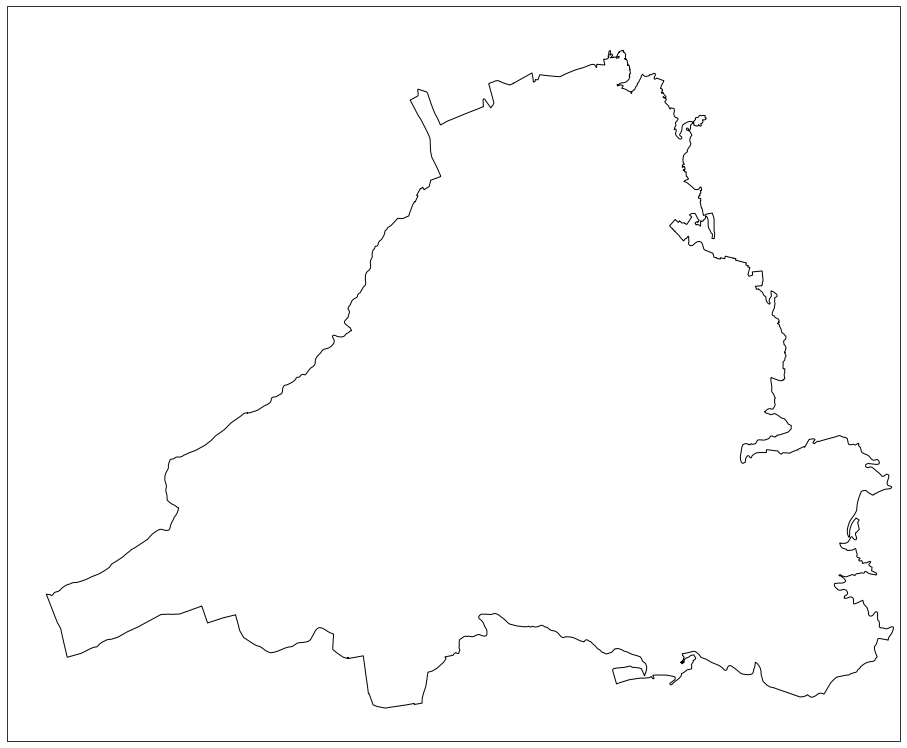

In [11]:
subplot_kw = dict(projection=ccrs.PlateCarree())

fig, ax = plt.subplots(figsize=(16, 16), subplot_kw=subplot_kw)

# Mapa de floridablanca
lower_lon = -73.135 #min(df['longitud'])
upper_lon = -73.073 #max(df['longitud'])
lower_lat = 7.051 #min(df['latitud'])
upper_lat = 7.102 #max(df['latitud'])

ax.set_extent([lower_lon, upper_lon, lower_lat, upper_lat])

reader = shapereader.Reader('68276_urbano.shp')

for urbano in reader.geometries():
    ax.add_geometries([urbano], ccrs.PlateCarree(), facecolor='white', edgecolor='black')
    #print(urbano)

ax.add_line
plt.show()

In [12]:
from pyproj import Geod
from shapely import wkt

polyMap = ""
for x in reader.geometries():
  polyMap = x

geod = Geod(ellps='WGS84')
poly = polyMap
points = np.array(poly)
print(points)

area = abs(geod.geometry_area_perimeter(poly)[0])
print(area)

POLYGON ((-73.07407285697673 7.069474056682395, -73.07406866523667 7.069476668313655, -73.07399633006656 7.069527112186506, -73.07394969302385 7.069546149035602, -73.07387259684282 7.069533775263551, -73.07384309188512 7.069512836348395, -73.07381739375768 7.069463343958205, -73.07380978009724 7.069370068973569, -73.07383928595425 7.069264421116202, -73.07391447557256 7.069024571027171, -73.07393256093889 7.068901791084841, -73.07391828330208 7.068836117193086, -73.07387735695443 7.068783768556102, -73.073835479124 7.068757118945939, -73.07371174590031 7.068719999428481, -73.07360990487319 7.068662891579208, -73.07362480574017 7.068626213628932, -73.07363233486433 7.068609649016139, -73.07364265188681 7.068586952825683, -73.07370073190322 7.068552104995717, -73.07371403557426 7.068544121713899, -73.07384609562075 7.06852984587573, -73.07385377043511 7.068528872809281, -73.07385384507887 7.068528863816084, -73.07409950928491 7.068497722991594, -73.07416574795087 7.068469656049842, -73.0

In [13]:
import math

def distancia(x1, y1, x2, y2):
  return math.sqrt((x2-x1)**2 + (y2-y1)**2)

In [14]:
def puntosCercanos (pointList, h):
  counter = 0
  pointOneIndex = 0
  for pointOne in pointList:
    if(pointOneIndex +1 < len(pointList)):
      for pointTwo in pointList[pointOneIndex + 1:len(pointList)]:
        if (distancia(pointOne[0],pointOne[1],pointTwo[0],pointTwo[1]) <= h):
          counter += 1
    pointOneIndex += 1
  return counter
def valorK(puntos, area, h):
  return (area/(len(puntos)**2)) * puntosCercanos(puntos,h)



In [15]:
import random
from shapely.geometry import Point
import matplotlib.path as mpltPath
import numpy as np
import multiprocessing

def temp(number, otherNum):
  print(otherNum)
  print(number)

def generadorPuntos(pointNumber, polygon):
  pointList = []
  for a in range(pointNumber):
    x = 0
    y = 0
    while (polygon.contains(Point(x, y)) == False): #(path.contains_points([[0,0]])[0] == False):
      x = random.uniform(lower_lon, upper_lon)
      y = random.uniform(lower_lat, upper_lat)
    pointList.append(list(P(x, y)))
  return pointList

In [16]:

# def spawn(num):
#   print('Spawned! {}'.format(num))

# for i in range(5):
#   p = multiprocessing.Process(target=spawn, args=(i,))
#   p.start()

In [17]:
# pointList = []
# procs = []
# for i in range(18):
#   proc = multiprocessing.Process(target=generadorPuntos, args=(1200,poly,))
#   procs.append(proc)
#   proc.start()

# for proc in procs:
#   proc.join()
#   #print(generadorPuntos(1200, poly))

In [18]:
def kCompleto(originalPointList, ranList, h):
  #print(ranList)
  result = []
  originalK = valorK(originalPointList, area, h)
  result.append(originalK)

  totalPoints = len(originalPointList)
  for randSet in ranList:
    result.append(valorK(randSet, area, h))
  result.sort()
  return [h, originalK, np.percentile(result, 2.5), np.percentile(result, 97.5)]

In [19]:
import time

def iterateK(originalPointList):
  result = []
  randList = []
  totalPoints = len(originalPointList)
  for i in range(999):
    print("\rDatos Aleatorios = " + str(i + 1), end='', flush=True)
    
    #ye = generadorPuntos(totalPoints,poly)
    randList.append(generadorPuntos(totalPoints,poly))
  print()
  for i in range(5,100,5):
    start_time = time.time()
    
    result.append(kCompleto(originalPointList, randList, i))
    print(str(i) + " - " + str(time.time()-start_time))
  return result


In [20]:
x_points = df['x']
y_points = df['y']
pointList = []
for index in range(len(x_points)):
  pointList.append([x_points[index], y_points[index]])

In [21]:
finalData = iterateK(pointList)

Datos Aleatorios = 999
5 - 382.8338963985443
10 - 382.3309144973755
15 - 383.2631232738495
20 - 382.4805700778961
25 - 383.5596652030945
30 - 384.1922903060913
35 - 383.50987458229065
40 - 385.9162440299988
45 - 386.8949728012085
50 - 388.25141310691833
55 - 385.6662771701813
60 - 385.27353954315186
65 - 385.1259517669678
70 - 384.19918179512024
75 - 383.2093780040741
80 - 381.51875352859497
85 - 382.85340309143066
90 - 382.9667749404907
95 - 385.36005568504333


In [22]:
dfResult = pd.DataFrame(finalData, columns=['h', 'K Original', '2.5', '97.5'])
dfResult

,h,K Original,2.5,97.5
0,5,1036.914234,10.689837,85.518700
1,10,2127.277656,85.251454,245.866262
2,15,3110.742703,235.176424,470.352848
3,20,4361.453686,459.663011,791.047972
4,25,5590.784995,758.978460,1175.882121
5,30,6948.394353,1133.122771,1635.545132
6,35,8861.875259,1624.855295,2180.726843
7,40,10337.072829,2170.037006,2801.004662
8,45,12336.072435,2757.978066,3485.154260
9,50,14687.836678,3463.507339,4254.555311


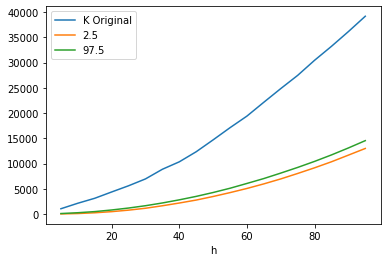

In [23]:
dfResult.plot(x="h", y=["K Original", "2.5", "97.5"])
plt.show()